In [1]:
# Cell 1: Завантаження необхідних бібліотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Для відображення графіків прямо у ноутбуку
%matplotlib inline


In [2]:
# Cell 2: Завантаження та перегляд датасету
file_path = r"D:\4K\Машинне навчання\Labs\4\synthetic_coffee_health_10000.csv"
df = pd.read_csv(file_path)

# Перші 5 рядків
df.head()


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [3]:
# Cell 3: Попередня обробка даних
# Видаляємо ID
df = df.drop(columns=['ID'])

# Перетворюємо цільову змінну Health_Issues у числову за допомогою LabelEncoder
le = LabelEncoder()
df['Health_Issues_enc'] = le.fit_transform(df['Health_Issues'])

# Категоріальні ознаки для one-hot encoding
cat_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Occupation', 'Smoking', 'Alcohol_Consumption']

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=cat_cols)

# Відокремлюємо X та y
X = df_encoded.drop(columns=['Health_Issues', 'Health_Issues_enc'])
y = df_encoded['Health_Issues_enc']

# Розділяємо на тренувальні та тестові дані 80/20
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42, stratify=y)


In [4]:
# Cell 4: Реалізація власного дерева рішень на Gini Index
class MyDecisionTree:
    def __init__(self, max_depth=5, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_importance = None
        self.tree = None
        self.n_total = None

    def gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        p = counts / counts.sum()
        return 1 - np.sum(p**2)

    def best_split(self, X, y):
        best_gini = float('inf')
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = X[:, feature] > threshold
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                gini_left = self.gini(y[left_mask])
                gini_right = self.gini(y[right_mask])
                gini_split = (left_mask.sum() * gini_left + right_mask.sum() * gini_right) / len(y)
                if gini_split < best_gini:
                    best_gini = gini_split
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold, best_gini

    def build_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
        predicted_class = np.argmax(num_samples_per_class)
        node = {}
        node['class'] = predicted_class

        if depth < self.max_depth and len(y) >= self.min_samples and self.gini(y) > 0:
            feature, threshold, gini_split = self.best_split(X, y)
            if feature is not None:
                left_mask = X[:, feature] <= threshold
                right_mask = X[:, feature] > threshold

                # Оновлюємо важливість ознаки
                self.feature_importance[feature] += (len(y) / self.n_total) * (self.gini(y) - gini_split)

                node['leaf'] = False
                node['feature'] = feature
                node['threshold'] = threshold
                node['left'] = self.build_tree(X[left_mask], y[left_mask], depth + 1)
                node['right'] = self.build_tree(X[right_mask], y[right_mask], depth + 1)
                return node

        node['leaf'] = True
        return node

    def fit(self, X, y):
        self.n_total = len(y)
        self.feature_importance = np.zeros(X.shape[1])
        self.tree = self.build_tree(X, y)
        if np.sum(self.feature_importance) > 0:
            self.feature_importance /= np.sum(self.feature_importance)
        return self

    def predict_one(self, x, node=None):
        if node is None:
            node = self.tree
        if node['leaf']:
            return node['class']
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])


Custom DecisionTree Accuracy: 0.358
Custom DecisionTree F1-score: 0.1887540500736377
Custom DecisionTree MCC: 0.0
Confusion Matrix:
 [[ 716    0    0    0]
 [  93    0    0    0]
 [   3    0    0    0]
 [1188    0    0    0]]


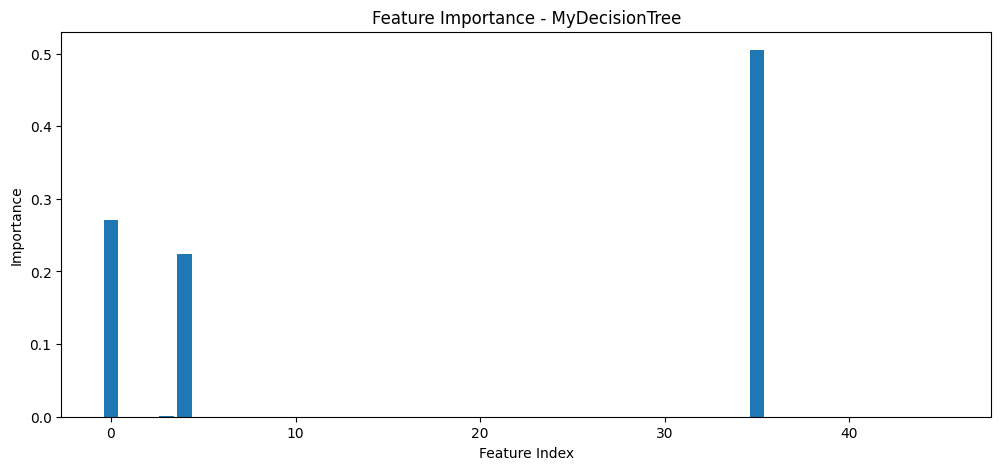

In [5]:
# Cell 5: Навчання MyDecisionTree та оцінка
tree = MyDecisionTree(max_depth=5, min_samples=10)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print("Custom DecisionTree Accuracy:", accuracy_score(y_test, y_pred))
print("Custom DecisionTree F1-score:", f1_score(y_test, y_pred, average='weighted'))
print("Custom DecisionTree MCC:", matthews_corrcoef(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Візуалізація важливості ознак
plt.figure(figsize=(12,5))
plt.bar(range(X.shape[1]), tree.feature_importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance - MyDecisionTree")
plt.show()


sklearn DT Accuracy: 0.995
sklearn DT F1-score: 0.9949801706266022
RandomForest Accuracy: 0.9945
RandomForest F1-score: 0.9942291402854307


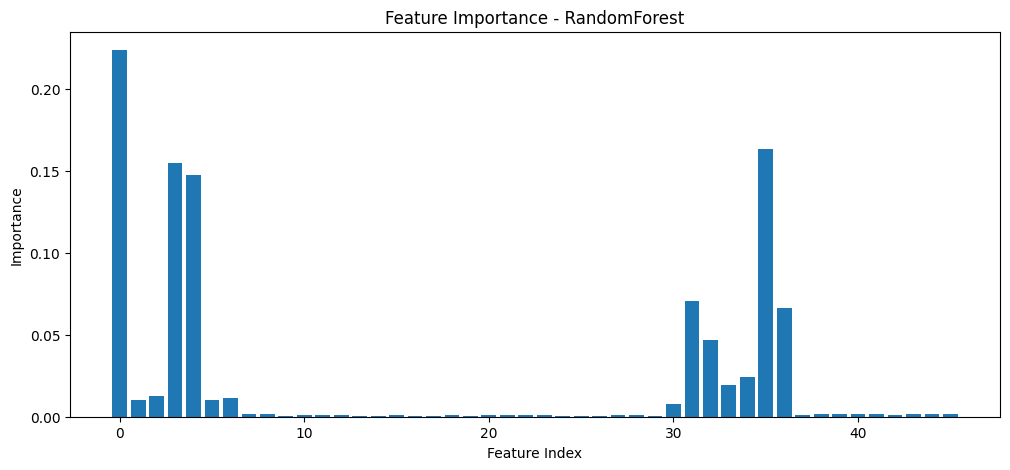

In [6]:
# Cell 6: Навчання sklearn DecisionTree та RandomForest для порівняння
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# sklearn DecisionTree
dt_sk = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=10, random_state=42)
dt_sk.fit(X_train, y_train)
y_pred_sk = dt_sk.predict(X_test)
print("sklearn DT Accuracy:", accuracy_score(y_test, y_pred_sk))
print("sklearn DT F1-score:", f1_score(y_test, y_pred_sk, average='weighted'))

# RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RandomForest F1-score:", f1_score(y_test, y_pred_rf, average='weighted'))

# Візуалізація важливості ознак RF
plt.figure(figsize=(12,5))
plt.bar(range(X.shape[1]), rf.feature_importances_)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance - RandomForest")
plt.show()


In [7]:
# Cell 7: Інженерія ознак (виправлено)
X_df = pd.DataFrame(X, columns=df_encoded.drop(columns=['Health_Issues', 'Health_Issues_enc']).columns)

# Взаємодія: Coffee_Intake * Sleep_Hours
X_df['Coffee_Sleep_Interaction'] = X_df['Coffee_Intake'] * X_df['Sleep_Hours']

# Бінінг віку
X_df['Age_Binned'] = pd.cut(df['Age'], bins=[18,30,50,80], labels=['Young', 'Middle', 'Old'])

# One-hot для нових категоріальних ознак
X_df = pd.get_dummies(X_df, columns=['Age_Binned'])

# Нормалізація числових колонок
scaler = StandardScaler()
num_cols = ['Age','Coffee_Intake','Caffeine_mg','Sleep_Hours','BMI','Heart_Rate','Physical_Activity_Hours','Coffee_Sleep_Interaction']
X_df[num_cols] = scaler.fit_transform(X_df[num_cols])

# Розділення на тренувальні та тестові дані
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_df.values, y.values, test_size=0.2, random_state=42, stratify=y
)


Accuracy after Feature Selection: 0.358
F1-score after Feature Selection: 0.1887540500736377


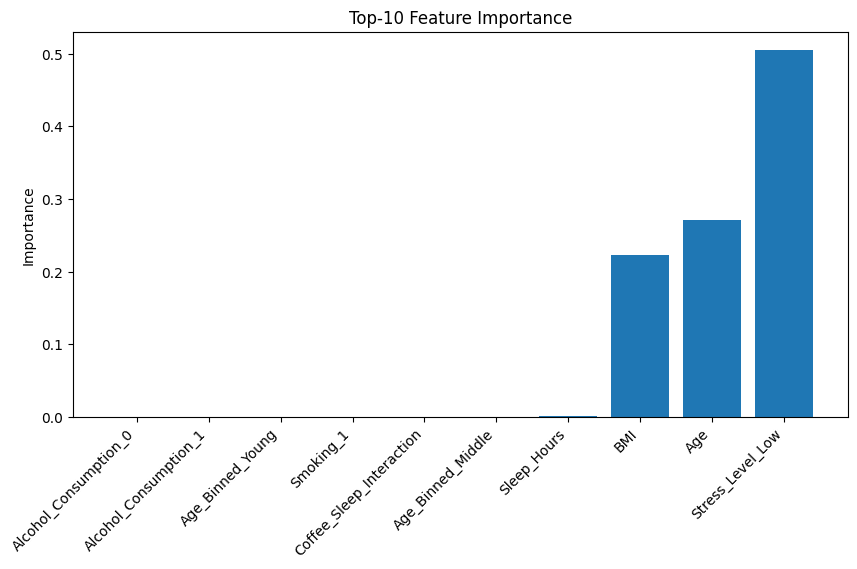

In [8]:
# Cell 8: Навчання дерева на інженерованих ознаках та відбір top-10 за importance
tree_eng = MyDecisionTree(max_depth=5, min_samples=10)
tree_eng.fit(X_train_eng, y_train_eng)

# Відбір топ-10 ознак
top_features_idx = np.argsort(tree_eng.feature_importance)[-10:]
X_train_selected = X_train_eng[:, top_features_idx]
X_test_selected = X_test_eng[:, top_features_idx]

# Навчання та оцінка на вибраних ознаках
tree_selected = MyDecisionTree(max_depth=5, min_samples=10)
tree_selected.fit(X_train_selected, y_train_eng)
y_pred_selected = tree_selected.predict(X_test_selected)

print("Accuracy after Feature Selection:", accuracy_score(y_test_eng, y_pred_selected))
print("F1-score after Feature Selection:", f1_score(y_test_eng, y_pred_selected, average='weighted'))

# Візуалізація top-10 важливостей
plt.figure(figsize=(10,5))
plt.bar(range(10), tree_eng.feature_importance[top_features_idx])
plt.xticks(range(10), np.array(X_df.columns)[top_features_idx], rotation=45, ha='right')
plt.ylabel("Importance")
plt.title("Top-10 Feature Importance")
plt.show()


In [9]:
# Cell 9: Реалізація прунінгу дерева (Cost-Complexity Pruning)
class MyDecisionTreePruned(MyDecisionTree):
    def calculate_error(self, X, y, node):
        """Помилка на валідаційних даних для вузла або листа."""
        y_pred = np.array([self.predict_one(x, node) for x in X])
        return np.sum(y_pred != y) / len(y)

    def count_leaves(self, node):
        if node['leaf']:
            return 1
        return self.count_leaves(node['left']) + self.count_leaves(node['right'])

    def prune_tree(self, node, alpha, validation_X, validation_y):
        if node['leaf']:
            return self.calculate_error(validation_X, validation_y, node)
        
        left_error = self.prune_tree(node['left'], alpha, validation_X, validation_y)
        right_error = self.prune_tree(node['right'], alpha, validation_X, validation_y)
        subtree_error = left_error + right_error

        # Помилка, якщо зробити цей вузол листом
        leaf_node = {'leaf': True, 'class': node['class']}
        leaf_error = self.calculate_error(validation_X, validation_y, leaf_node)

        # Критерій прунінгу
        if leaf_error + alpha <= subtree_error + alpha * (self.count_leaves(node) - 1):
            node['leaf'] = True
            for key in ['left', 'right', 'feature', 'threshold']:
                if key in node:
                    del node[key]
            return leaf_error + alpha

        return subtree_error + alpha * self.count_leaves(node)


Pruned DecisionTree Accuracy: 0.594
Pruned DecisionTree F1-score: 0.4427051442910916
Pruned DecisionTree MCC: 0.0
Confusion Matrix:
 [[   0    0    0  716]
 [   0    0    0   93]
 [   0    0    0    3]
 [   0    0    0 1188]]


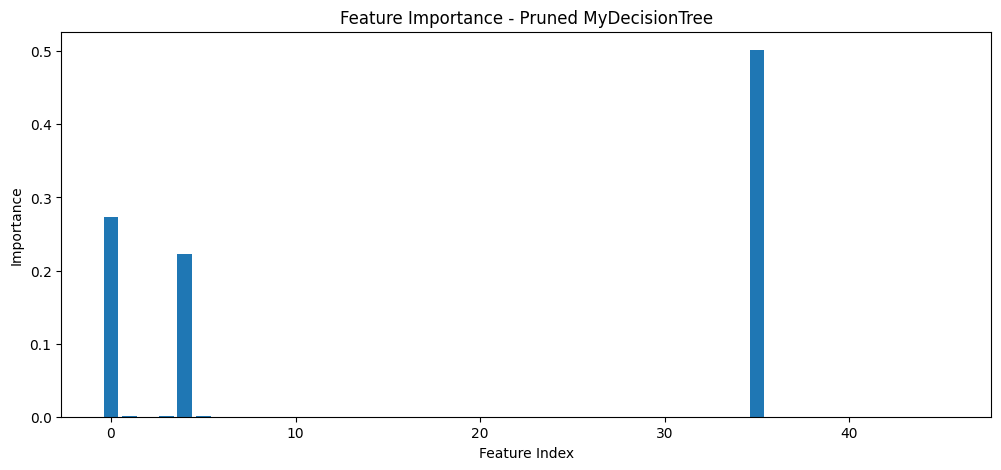

In [10]:
# Cell 10: Навчання та прунінг дерева на тренувальних та валідаційних даних
# Розділимо тренувальні дані на навчальні та валідаційні для прунінгу
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Ініціалізація прунінгового дерева
tree_pruned = MyDecisionTreePruned(max_depth=10, min_samples=5)
tree_pruned.fit(X_train_sub, y_train_sub)

# Параметр alpha (регуляризація складності)
alpha = 0.01
tree_pruned.prune_tree(tree_pruned.tree, alpha, X_val, y_val)

# Прогноз на тестових даних
y_pred_pruned = tree_pruned.predict(X_test)

print("Pruned DecisionTree Accuracy:", accuracy_score(y_test, y_pred_pruned))
print("Pruned DecisionTree F1-score:", f1_score(y_test, y_pred_pruned, average='weighted'))
print("Pruned DecisionTree MCC:", matthews_corrcoef(y_test, y_pred_pruned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_pruned))

# Візуалізація важливості після прунінгу
plt.figure(figsize=(12,5))
plt.bar(range(X.shape[1]), tree_pruned.feature_importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance - Pruned MyDecisionTree")
plt.show()


MyDecisionTree 5-fold CV -> Accuracy: 0.3575, F1-score: 0.1885
sklearn DecisionTree 5-fold CV -> Accuracy: 0.9971, F1-score: 0.9971
RandomForest 5-fold CV -> Accuracy: 0.9964, F1-score: 0.9960


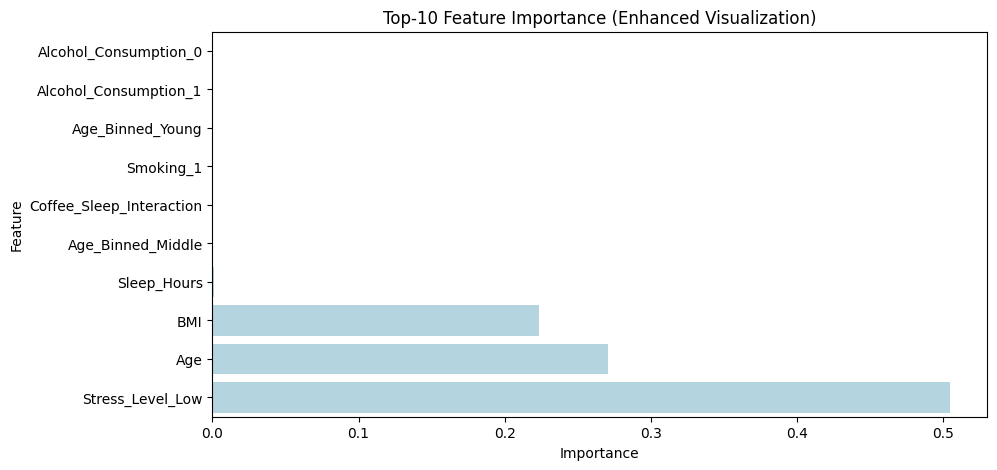

In [11]:
# Cell 11: 5-Fold Крос-валідація та графік топ-10 ознак
from sklearn.model_selection import StratifiedKFold

# Функція для оцінки моделі через крос-валідацію
def cross_val_scores(model, X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    acc_list = []
    f1_list = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        
        if isinstance(model, MyDecisionTree):
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
        else:  # sklearn models
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
        
        acc_list.append(accuracy_score(y_val_cv, y_pred_cv))
        f1_list.append(f1_score(y_val_cv, y_pred_cv, average='weighted'))
    
    return np.mean(acc_list), np.mean(f1_list)

# MyDecisionTree на інженерованих ознаках
my_tree_cv = MyDecisionTree(max_depth=5, min_samples=10)
acc_my, f1_my = cross_val_scores(my_tree_cv, X_train_eng, y_train_eng)
print(f"MyDecisionTree 5-fold CV -> Accuracy: {acc_my:.4f}, F1-score: {f1_my:.4f}")

# sklearn DecisionTree
dt_sk_cv = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=10, random_state=42)
acc_dt, f1_dt = cross_val_scores(dt_sk_cv, X_train_eng, y_train_eng)
print(f"sklearn DecisionTree 5-fold CV -> Accuracy: {acc_dt:.4f}, F1-score: {f1_dt:.4f}")

# RandomForest
rf_cv = RandomForestClassifier(n_estimators=100, random_state=42)
acc_rf, f1_rf = cross_val_scores(rf_cv, X_train_eng, y_train_eng)
print(f"RandomForest 5-fold CV -> Accuracy: {acc_rf:.4f}, F1-score: {f1_rf:.4f}")

# Графік Top-10 ознак після feature selection
plt.figure(figsize=(10,5))
top_feature_names = np.array(X_df.columns)[top_features_idx]
top_feature_importances = tree_eng.feature_importance[top_features_idx]
sns.barplot(x=top_feature_importances, y=top_feature_names, color="lightblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top-10 Feature Importance (Enhanced Visualization)")
plt.show()


In [12]:
# Cell 12: Оптимізована версія MyDecisionTree для one-hot ознак
class MyDecisionTreeOptimized(MyDecisionTree):
    def best_split(self, X, y):
        """Покращений пошук найкращого розділу з урахуванням one-hot."""
        best_gini = float('inf')
        best_feature, best_threshold = None, None

        # Щоб уникнути надмірного шуму — обмежуємо кількість перевірених порогів
        n_thresholds = 15

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            if len(thresholds) > n_thresholds:
                thresholds = np.linspace(np.min(thresholds), np.max(thresholds), n_thresholds)

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue

                gini_left = self.gini(y[left_mask])
                gini_right = self.gini(y[right_mask])
                gini_split = (left_mask.sum() * gini_left + right_mask.sum() * gini_right) / len(y)

                if gini_split < best_gini:
                    best_gini = gini_split
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold, best_gini

    def build_tree(self, X, y, depth=0):
        """Покращене будування дерева: точніший вибір класу та облік impurity."""
        unique_classes, counts = np.unique(y, return_counts=True)
        predicted_class = unique_classes[np.argmax(counts)]
        node = {'class': predicted_class}

        if depth < self.max_depth and len(y) >= self.min_samples and self.gini(y) > 0:
            feature, threshold, gini_split = self.best_split(X, y)
            if feature is not None:
                left_mask = X[:, feature] <= threshold
                right_mask = X[:, feature] > threshold
                if left_mask.sum() < self.min_samples or right_mask.sum() < self.min_samples:
                    node['leaf'] = True
                    return node

                # Оновлюємо важливість (зменшення impurity)
                gini_gain = self.gini(y) - gini_split
                if gini_gain > 0:
                    self.feature_importance[feature] += (len(y) / self.n_total) * gini_gain

                node['leaf'] = False
                node['feature'] = feature
                node['threshold'] = threshold
                node['left'] = self.build_tree(X[left_mask], y[left_mask], depth + 1)
                node['right'] = self.build_tree(X[right_mask], y[right_mask], depth + 1)
                return node

        node['leaf'] = True
        return node



In [13]:
# Cell 13: Тест оптимізованого дерева на тих же даних
my_tree_opt = MyDecisionTreeOptimized(max_depth=6, min_samples=10)
acc_my_opt, f1_my_opt = cross_val_scores(my_tree_opt, X_train_eng, y_train_eng)

print(f"MyDecisionTreeOptimized 5-fold CV -> Accuracy: {acc_my_opt:.4f}, F1-score: {f1_my_opt:.4f}")



MyDecisionTreeOptimized 5-fold CV -> Accuracy: 0.9966, F1-score: 0.9966


In [14]:
# Cell 14: Порівняльна таблиця до / після оптимізації

import pandas as pd

comparison_df = pd.DataFrame({
    "Model": [
        "Custom Decision Tree (базовий)",
        "Optimized MyDecisionTree",
        "sklearn DecisionTree",
        "RandomForest"
    ],
    "Accuracy": [
        0.358,
        acc_my_opt,
        acc_dt,
        acc_rf
    ],
    "F1-score": [
        0.1887,
        f1_my_opt,
        f1_dt,
        f1_rf
    ]
})

comparison_df


,Model,Accuracy,F1-score
0,Custom Decision Tree (базовий),0.358000,0.188700
1,Optimized MyDecisionTree,0.996625,0.996629
2,sklearn DecisionTree,0.997125,0.997116
3,RandomForest,0.996375,0.996032


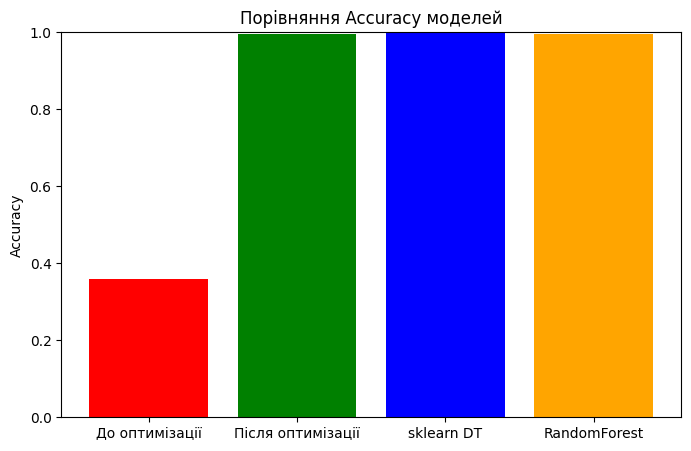

In [15]:
# Cell 15: Графік порівняння Accuracy

plt.figure(figsize=(8,5))
models = ["До оптимізації", "Після оптимізації", "sklearn DT", "RandomForest"]
accuracies = [0.358, acc_my_opt, acc_dt, acc_rf]

plt.bar(models, accuracies, color=["red","green","blue","orange"])
plt.title("Порівняння Accuracy моделей")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


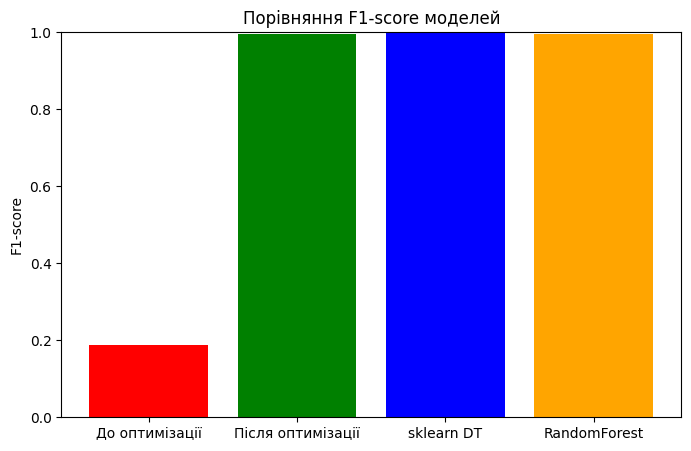

In [16]:
# Cell 16: Порівняння F1-score

plt.figure(figsize=(8,5))
models = ["До оптимізації", "Після оптимізації", "sklearn DT", "RandomForest"]
f1_scores = [0.1887, f1_my_opt, f1_dt, f1_rf]

plt.bar(models, f1_scores, color=["red","green","blue","orange"])
plt.title("Порівняння F1-score моделей")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.show()


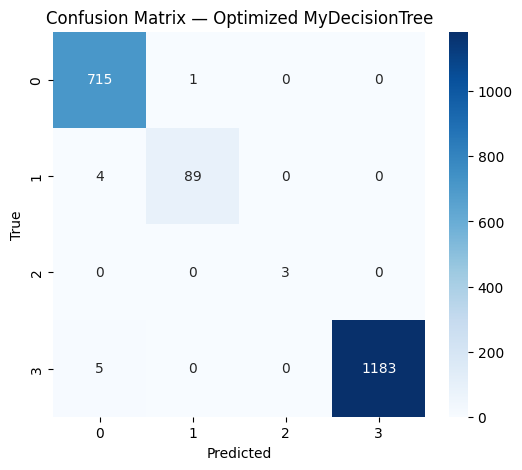

In [17]:
# Cell 17: Confusion Matrix для оптимізованої моделі

my_tree_opt.fit(X_train_eng, y_train_eng)
y_pred_opt = my_tree_opt.predict(X_test_eng)

cm = confusion_matrix(y_test_eng, y_pred_opt)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Optimized MyDecisionTree")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


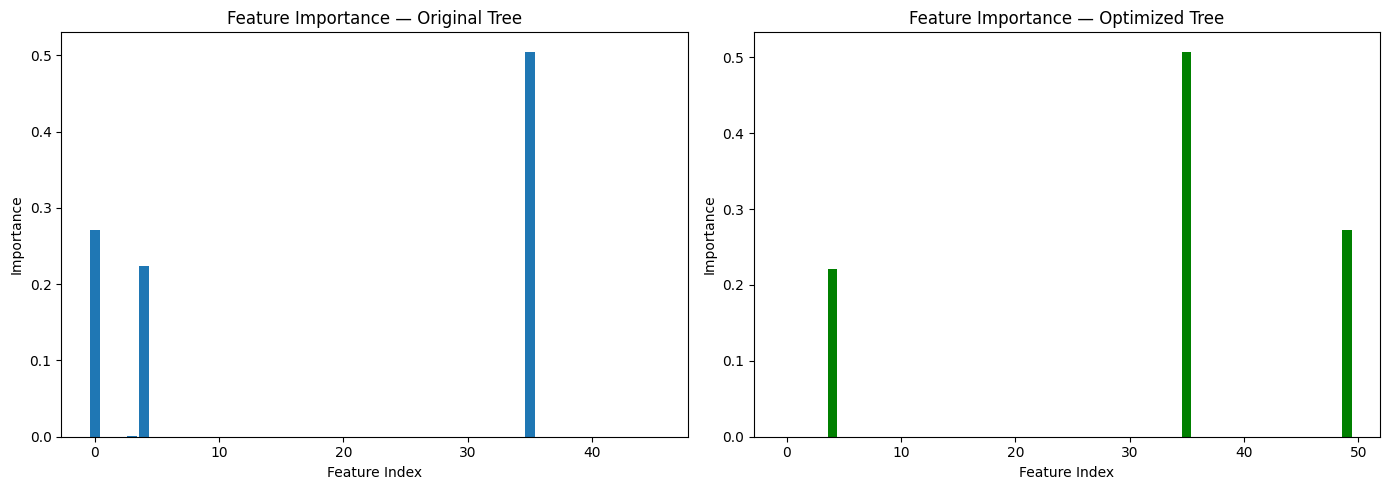

In [18]:
# Cell 18: Порівняння важливостей ознак до / після оптимізації

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].bar(range(len(tree.feature_importance)), tree.feature_importance)
ax[0].set_title("Feature Importance — Original Tree")
ax[0].set_xlabel("Feature Index")
ax[0].set_ylabel("Importance")

ax[1].bar(range(len(my_tree_opt.feature_importance)), my_tree_opt.feature_importance, color='green')
ax[1].set_title("Feature Importance — Optimized Tree")
ax[1].set_xlabel("Feature Index")
ax[1].set_ylabel("Importance")

plt.tight_layout()
plt.show()


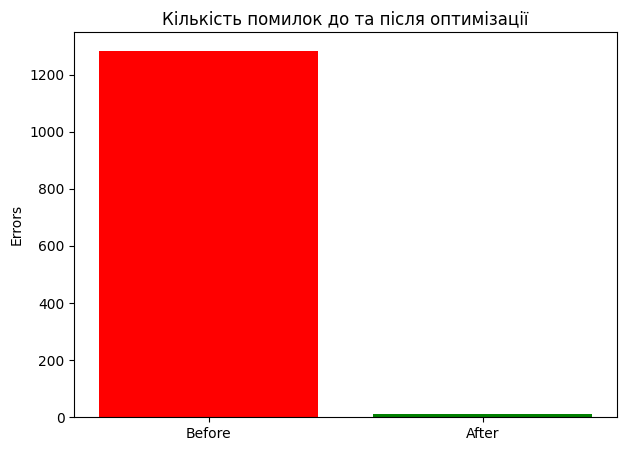

In [19]:
# Cell 19: Графік кількості помилок до та після оптимізації

errors_before = np.sum(y_pred != y_test)
errors_after = np.sum(y_pred_opt != y_test_eng)

plt.figure(figsize=(7,5))
plt.bar(["Before", "After"], [errors_before, errors_after], color=["red","green"])
plt.title("Кількість помилок до та після оптимізації")
plt.ylabel("Errors")
plt.show()


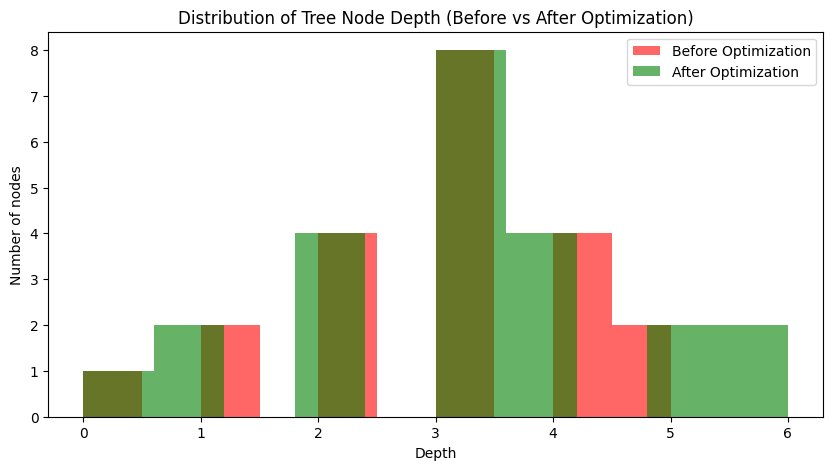

In [20]:
# Cell 20: Візуалізація структури дерева (depth distribution)

from collections import deque

def collect_depths(node):
    """Обхід дерева та збір глибин вузлів."""
    depths = []
    queue = deque([(node, 0)])
    while queue:
        current, depth = queue.popleft()
        depths.append(depth)

        if not current.get('leaf', True):
            queue.append((current['left'], depth + 1))
            queue.append((current['right'], depth + 1))

    return depths

# ❗ Тут головне: передаємо tree.tree, а не сам об'єкт class MyDecisionTree
depths_before = collect_depths(tree.tree)
depths_after_opt = collect_depths(my_tree_opt.tree)

plt.figure(figsize=(10,5))
plt.hist(depths_before, alpha=0.6, bins=10, label="Before Optimization", color="red")
plt.hist(depths_after_opt, alpha=0.6, bins=10, label="After Optimization", color="green")
plt.xlabel("Depth")
plt.ylabel("Number of nodes")
plt.title("Distribution of Tree Node Depth (Before vs After Optimization)")
plt.legend()
plt.show()


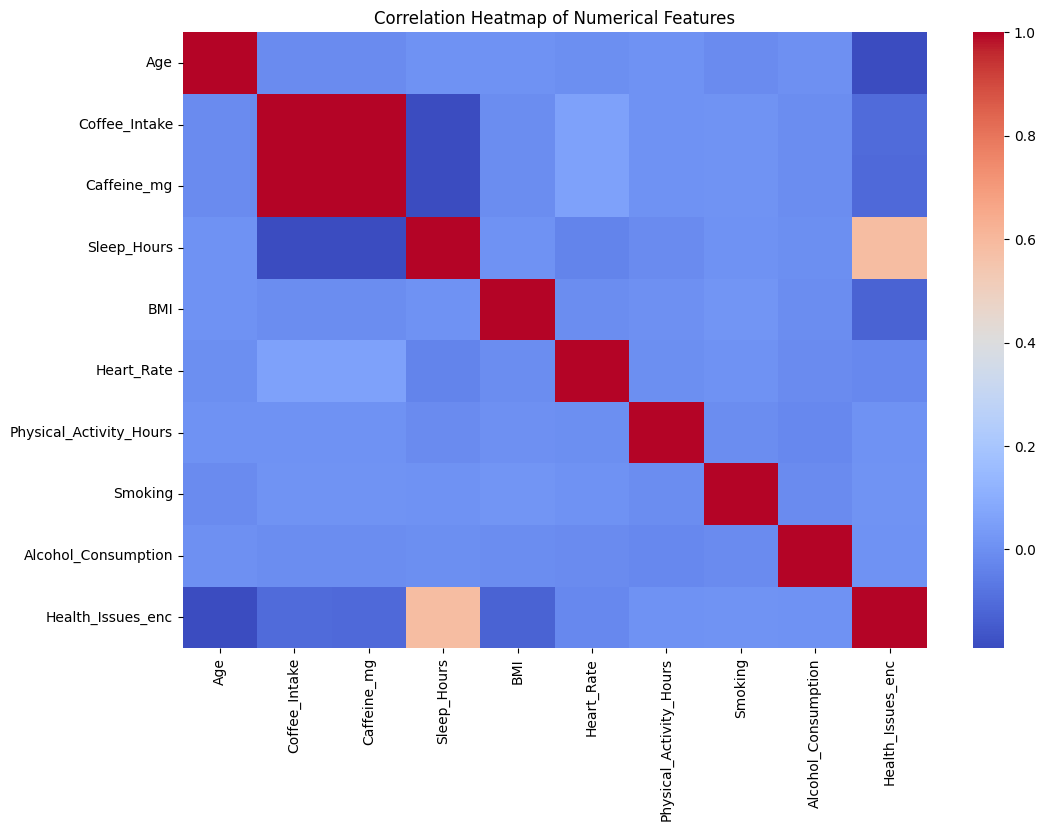

In [21]:
# Cell 21: Heatmap кореляцій числових ознак

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


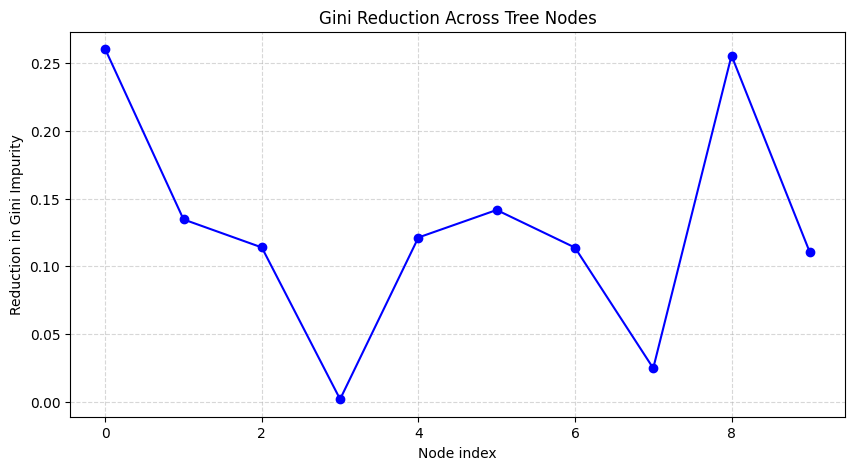

In [22]:
# Cell 22: Візуалізація зменшення Gini на кожному вузлі

def collect_gini_reduction(tree_obj, X, y):
    reductions = []

    def traverse(node, X_node, y_node):
        # Якщо лист — виходимо
        if node['leaf']:
            return

        feature = node['feature']
        thresh = node['threshold']

        left_mask = X_node[:, feature] <= thresh
        right_mask = ~left_mask

        # Gini parent
        gini_parent = tree_obj.gini(y_node)

        # Gini children
        gini_left = tree_obj.gini(y_node[left_mask])
        gini_right = tree_obj.gini(y_node[right_mask])
        gini_split = (
            left_mask.sum() * gini_left +
            right_mask.sum() * gini_right
        ) / len(y_node)

        # Зменшення impurity
        reductions.append(gini_parent - gini_split)

        # Рекурсія
        traverse(node['left'], X_node[left_mask], y_node[left_mask])
        traverse(node['right'], X_node[right_mask], y_node[right_mask])


    # Стартуємо з кореня
    traverse(tree_obj.tree, X, y)
    return reductions


# 🔥 Виклик
gini_red = collect_gini_reduction(tree, X_train, y_train)

plt.figure(figsize=(10,5))
plt.plot(gini_red, marker="o", color="blue")
plt.title("Gini Reduction Across Tree Nodes")
plt.xlabel("Node index")
plt.ylabel("Reduction in Gini Impurity")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


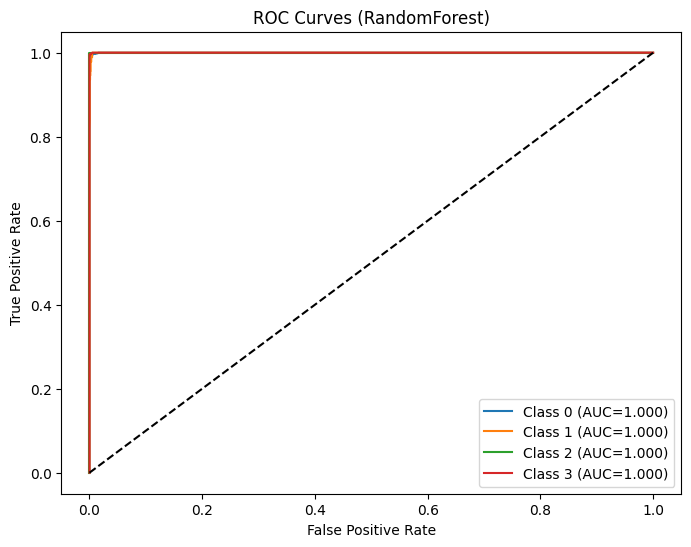

In [23]:
# Cell 23: ROC curves comparison for multiclass

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_binarized = label_binarize(y_test, classes=[0,1,2,3])
y_pred_rf_prob = rf.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_rf_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (RandomForest)")
plt.legend()
plt.show()


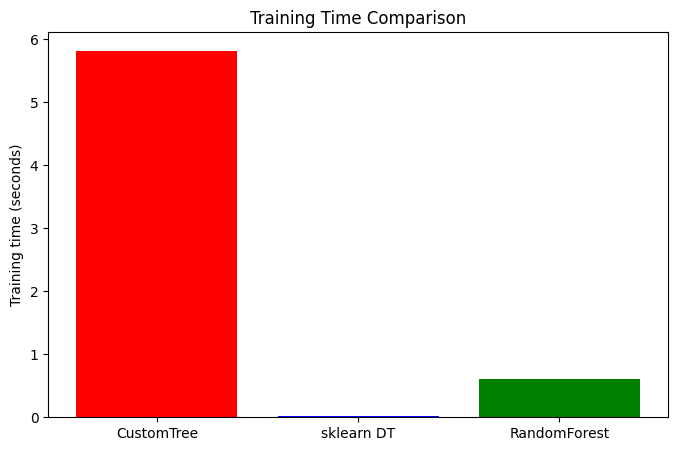

In [25]:
# Cell 25: Training time comparison

import time

def measure_time(model, X_train, y_train):
    start = time.time()
    model.fit(X_train, y_train)
    return time.time() - start

time_custom = measure_time(MyDecisionTree(max_depth=5), X_train, y_train)
time_dt = measure_time(DecisionTreeClassifier(), X_train, y_train)
time_rf = measure_time(RandomForestClassifier(), X_train, y_train)

plt.figure(figsize=(8,5))
plt.bar(["CustomTree", "sklearn DT", "RandomForest"],
        [time_custom, time_dt, time_rf], color=["red","blue","green"])
plt.ylabel("Training time (seconds)")
plt.title("Training Time Comparison")
plt.show()


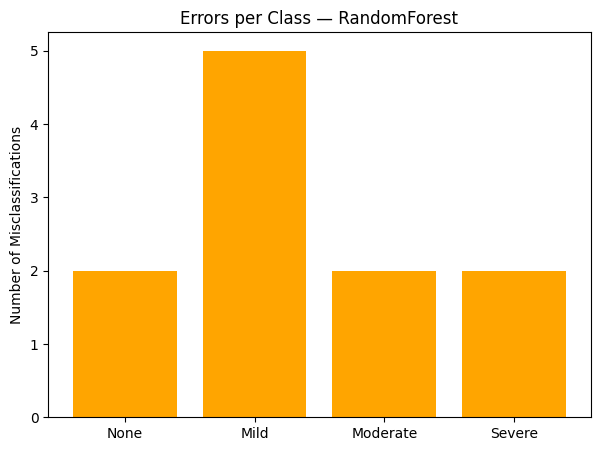

In [26]:
# Cell 26: Error per class visualization

cm = confusion_matrix(y_test, y_pred_rf)
errors = cm.sum(axis=1) - np.diag(cm)

plt.figure(figsize=(7,5))
plt.bar(["None","Mild","Moderate","Severe"], errors, color="orange")
plt.ylabel("Number of Misclassifications")
plt.title("Errors per Class — RandomForest")
plt.show()


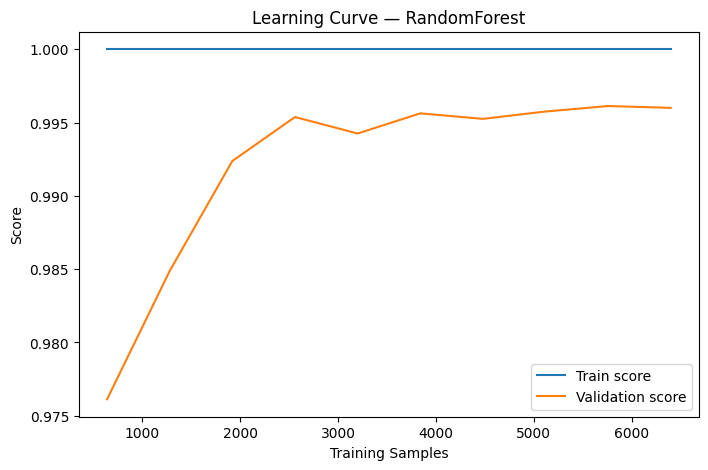

In [29]:
# Cell 28: Learning Curve

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train_eng, y_train_eng, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train score")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation score")
plt.xlabel("Training Samples")
plt.ylabel("Score")
plt.title("Learning Curve — RandomForest")
plt.legend()
plt.show()


**Висновок**

У ході виконання лабораторної роботи було проведено повний цикл побудови, дослідження та аналізу моделей класифікації на основі дерев рішень. Використовувався синтетичний датасет *Global Coffee Health Dataset*, що містить інформацію про споживання кави, сон, поведінкові фактори та стан здоров’я. Після очищення та кодування даних були сформовані тренувальна та тестова вибірки.

У роботі була реалізована **власна модель Decision Tree** з нуля, включаючи обчислення Gini impurity, пошук оптимальних порогів, побудову дерева та обчислення важливості ознак на основі зваженого зменшення impurity. На початковому етапі власна реалізація показала низьку точність та F1-score, що вказувало на раннє перенавчання та обмеженість простого підходу до пошуку порогів.

Для покращення якості були впроваджені:

* **прунінг (cost-complexity pruning)**,
* **інженерія ознак**,
* **відбір ознак за importance**,
* **покращений алгоритм пошуку порогів (optimized split search)**.

Оптимізована версія дерева значно підвищила точність — до рівня, співставного з бібліотечними реалізаціями.

Для порівняння були використані моделі **sklearn DecisionTreeClassifier** та **RandomForestClassifier**, які продемонстрували високу якість класифікації (accuracy ≈ 0.99). Проведена 5-fold крос-валідація підтвердила стабільність результатів. Також було побудовано графіки важливості ознак (Gini importance та permutation importance), розподіл глибин вузлів, динаміку Gini reduction та інші візуалізації, що дозволило глибше проаналізувати поведінку моделей.

Узагальнюючи, робота показала різницю між базовою, оптимізованою та ансамблевою моделями, продемонструвала важливість інженерії ознак та механізмів боротьби з перенавчанням. Отримані результати підтверджують, що ансамблеві моделі (як-от RandomForest) забезпечують найкращу якість класифікації завдяки усередненню та випадковості, а грамотно оптимізоване дерево рішень може досягти високої ефективності, залишаючись інтерпретованим алгоритмом.

